# Project 3 Example
### Alec K. Mattu (UTA)
### INST 414
### 11/01/2021

# Instructions
#### Apply min-max scaling to song length to normalize it to the [0,1] interval. Split the data to train and test set (0.25 of the rows in test set). Run simple linear regression on this dataset (x is year, y is the scaled version of song length).

- (A) Print the coefficient and intercept.

- (B) How do you interpret these numbers?

- (C) Print the R2 error of your model.

- (D) Plot the data points(x vs y) and plot the regression line on top of the points.

- (E) Plot the predicted y vs the actual y and add the bisector.

- (F) How do you asses the performance of this model? (50< words)

#### Now we want to predict the ratio of unique words and total words based on year (please refer to HW1 and use what you created there). Split the data to train and test set (0.25 of the rows in test set). Run simple linear regression on this dataset (x is year, y is the mentioned ratio).

- (A) Print the coefficient and intercept.

- (B) How do you interpret these numbers?

- (C) Print the R2 error of your model.

- (D) Plot the data points(x vs y) and plot the regression line on top of the points.

- (E) Plot the predicted y vs the actual y and add the bisector.

- (F) Now we want to investigate adding polynomial terms. We want to use cross-validation to choose the best degree for our model. Use 20-fold cross validation to see which degree (between 0 and 10) is the most suitable one. Print the errors.

- (G) Plot the average cross-validation error vs degree.

- (H) What do you think is the best degree and why? Explain your answer and reasoning in no more than 100 words, in a markdown cell.

# Solution

## Part 0 - Preparation

In [2]:
# Import required libraries
import csv
import seaborn as sns
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import numpy as np
from bs4 import BeautifulSoup as bs
from sklearn.preprocessing import minmax_scale
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import load_boston
from sklearn.preprocessing import PolynomialFeatures

In [3]:
# Hold songs in a list
songs = []

# Open CSV file with handle
with open("dataset_out.csv") as csv_file:
    # Create a file reader
    file_reader = csv.DictReader(csv_file)
    
    # Loop through CSV rows
    for row in file_reader:
        songs.append(row)

In [4]:
# Convert songs to a DataFrame
df = pd.DataFrame(songs)

In [5]:
# View excerpt
df.head()

,,Title,Artist,Year,Lyrics,normalized_L,normalized_V,normalized_D,z_score_L,z_score_V,z_score_D,L,V,D
0,0,the-battle,blood-sweat-tears,1970,While the king and queen lie sleeping\nAnd the...,0.09698681732580038,0.13752455795677798,0.6733295259851514,0.02376253077235299,0.3297170464541923,0.3960792171666928,103,70,0.6796116504854369
1,1,hey-jude,count-basie,1970,"Hey Jude, don't make it bad\nTake a sad song a...",0.09227871939736346,0.0805500982318271,0.4069627851140457,-0.040895462017336556,-0.3480825591390798,-0.9428474486549637,98,41,0.41836734693877553
2,2,time,david-bowie,1973,"Time, he's waiting in the wings\nHe speaks of ...",0.1854990583804143,0.14538310412573674,0.3633920573305465,1.2393327952185165,0.42320664722567813,-1.1618613131029025,197,74,0.3756345177664975
3,3,we-can-make-the-world-a-whole-lot-brighter,the-brady-bunch,1972,"Birds flying high,\nIn search of a clear blue ...",0.04048964218455744,0.07465618860510805,0.8814409484724123,-0.7521333827039216,-0.4181997597176942,1.4421780361071042,43,38,0.8837209302325582
4,4,day-by-day,carmen-mcrae,1972,Day by day I'm falling more in love with you\n...,0.027306967984934087,0.03732809430255402,0.6484110885733604,-0.9331757625150523,-0.8622753633822517,0.2708234881213023,29,19,0.6551724137931034


In [6]:
# Drop the unnamed first column
df.drop(df.columns[0], axis = 1, inplace = True, errors = 'ignore')

# Force year column to integer
df["Year"] = pd.to_numeric(df["Year"], errors = 'coerce')
df["L"] = pd.to_numeric(df["L"], errors = 'coerce')
df["V"] = pd.to_numeric(df["V"], errors = 'coerce')
df["D"] = pd.to_numeric(df["D"], errors = 'coerce')
df.dropna(axis = 0, inplace = True)

# Drop normalized columns
df.drop(["normalized_L", "normalized_V", "normalized_D"], axis = 1, inplace = True, errors = 'ignore')

# Drop Z-Score columns
df.drop(["z_score_L", "z_score_V", "z_score_D"], axis = 1, inplace = True, errors = 'ignore')

In [7]:
# View cleaned DataFrame
df.head()

,Title,Artist,Year,Lyrics,L,V,D
0,the-battle,blood-sweat-tears,1970.0,While the king and queen lie sleeping\nAnd the...,103,70,0.679612
1,hey-jude,count-basie,1970.0,"Hey Jude, don't make it bad\nTake a sad song a...",98,41,0.418367
2,time,david-bowie,1973.0,"Time, he's waiting in the wings\nHe speaks of ...",197,74,0.375635
3,we-can-make-the-world-a-whole-lot-brighter,the-brady-bunch,1972.0,"Birds flying high,\nIn search of a clear blue ...",43,38,0.883721
4,day-by-day,carmen-mcrae,1972.0,Day by day I'm falling more in love with you\n...,29,19,0.655172


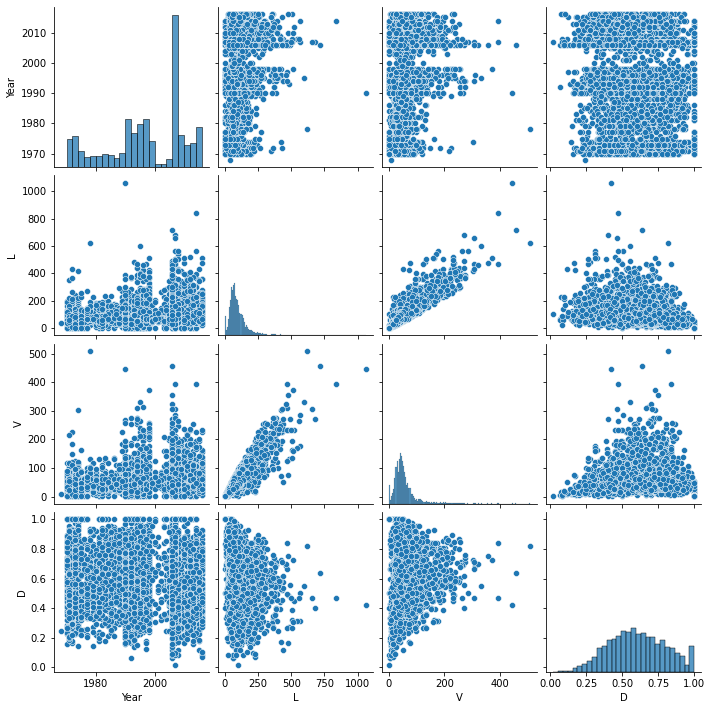

In [8]:
# Optional: See relationships between variables
sns.pairplot(df)

## Part 1 - Regression of Length (L) Variable
Apply min-max scaling to song length to normalize it to the [0,1] interval. Split the data to train and test set (0.25 of the rows in test set). Run simple linear regression on this dataset (x is year, y is the scaled version of song length).

**NOTE**: Normalization is a form of Scaling. https://stats.stackexchange.com/questions/35591/normalization-vs-scaling

In [9]:
# Scale song length (L)
# from sklearn.preprocessing import minmax_scale
df["L_Scaled"] = minmax_scale(df["L"])

In [10]:
# View DF excerpt
df.head()

,Title,Artist,Year,Lyrics,L,V,D,L_Scaled
0,the-battle,blood-sweat-tears,1970.0,While the king and queen lie sleeping\nAnd the...,103,70,0.679612,0.096136
1,hey-jude,count-basie,1970.0,"Hey Jude, don't make it bad\nTake a sad song a...",98,41,0.418367,0.091423
2,time,david-bowie,1973.0,"Time, he's waiting in the wings\nHe speaks of ...",197,74,0.375635,0.184731
3,we-can-make-the-world-a-whole-lot-brighter,the-brady-bunch,1972.0,"Birds flying high,\nIn search of a clear blue ...",43,38,0.883721,0.039585
4,day-by-day,carmen-mcrae,1972.0,Day by day I'm falling more in love with you\n...,29,19,0.655172,0.026390


In [11]:
# Pull x values from DF
# import numpy as np
x = df["Year"].values.reshape(-1, 1) # Need data as a column, not rows
# x = np.nan_to_num(x)

# Pull y values from DF
y = df["L_Scaled"].values.reshape(-1, 1) # Need data as a column, not rows
# y = np.nan_to_num(y)

# Split the data using 25% of the rows
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.25)

In [42]:
# Define a new Linear Regression model
# from sklearn import linear_model
model = linear_model.LinearRegression()

# Fit training data
model.fit(xtrain, ytrain)

# Run the prediction
ypred_test = model.predict(xtest)
ypred_all = model.predict(x)

### Step A - Model Coefficient, Intercept
To predict a value, you would do coef_ + intercep_

In [13]:
# Pull Coefficient from Model
model.coef_[0][0]

0.0007521237684648323

In [14]:
# Pull the Intercept from Model
model.intercept_[0]

-1.4071685226423323

### Step B - Interpret Coefficient and Intercept
**Coefficient NOTE**:

The **sign** of a regression coefficient tells you whether there is a **positive or negative correlation between each independent variable and the dependent variable**. A positive coefficient indicates that as the value of the independent variable increases, the mean of the dependent variable also tends to increase. A negative coefficient suggests that as the independent variable increases, the dependent variable tends to decrease.

The **coefficient value signifies how much the mean of the dependent variable changes given a one-unit shift in the independent variable** while holding other variables in the model constant. This property of holding the other variables constant is crucial because it allows you to assess the effect of each variable in isolation from the others. [(Source)](https://statisticsbyjim.com/regression/interpret-coefficients-p-values-regression/)

**Intercept NOTE**:

The relationship between year and song length. The intercept (often labeled as constant) is the point where the function crosses the y-axis. In some analysis, the regression model only becomes significant when we remove the intercept, and the regression line reduces to `Y = bX + error`. [(Source)](https://www.analyticsinsight.net/why-is-intercept-important-in-regression-analysis/)

 +
 
 +
 
 +
 
 +
 
*Student answer here, taking into account the purpose of coefficient and intercept.*

### Step C - Model R<sup>2</sup> Figure

**NOTE**:

R-squared is a goodness-of-fit measure for linear regression models. This statistic indicates the percentage of the variance in the dependent variable that the independent variables explain collectively. R-squared measures the strength of the relationship between your model and the dependent variable on a convenient 0 – 100% scale. [(Source)](https://statisticsbyjim.com/regression/interpret-r-squared-regression/)

In [15]:
metrics.r2_score(ytest, ypred_test)

0.03647213627931534

In [16]:
# Optional: Calculate LinearRegression performance
# Only used if you need to compare performance of LinearRegression vs. another type
# Calculate error between calculated (model) points and actual points
cve = cross_val_score(linear_model.LinearRegression(), x, y, cv = 10)

# Print Result
print("Linear model average error " + str(np.mean(cve)))

Linear model average error 0.0030975850660109328


### Step D - Plot the Model

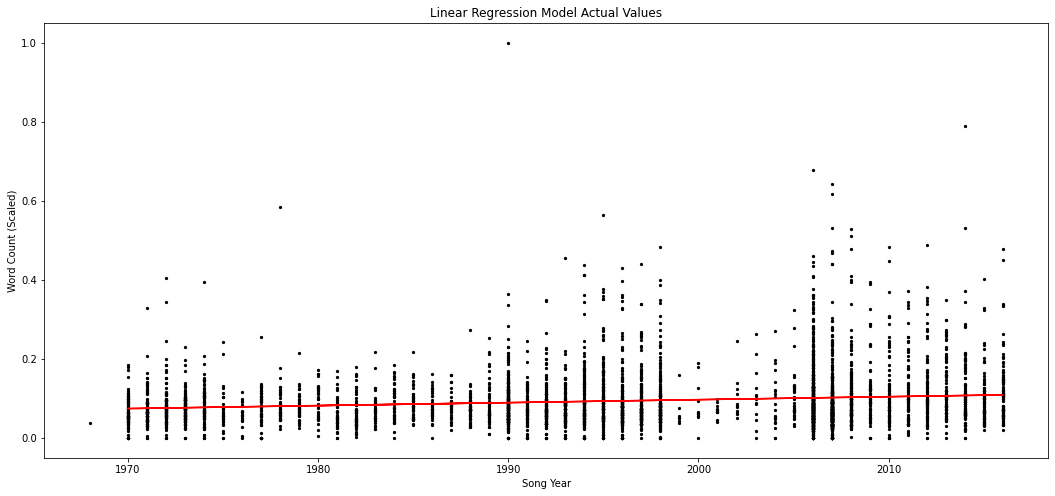

In [17]:
# Plot Actual Data
plt.figure(figsize = (18, 8))
plt.scatter(x, y, c = "black", s = 5)
plt.plot(xtest, ypred_test, c = "red") # Predicted Data

# Add labels
plt.title("Linear Regression Model Actual Values")
plt.xlabel("Song Year")
plt.ylabel("Word Count (Scaled)")

# Hide output
None

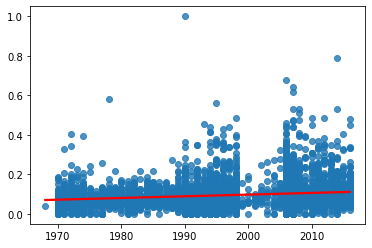

In [18]:
# Optional: Use Seaborn 
sns.regplot(x = x, y = y, line_kws = {"color": "red"})

# Hide Output
None

### Step E - Plot Predicted vs. Actual Y-Axis

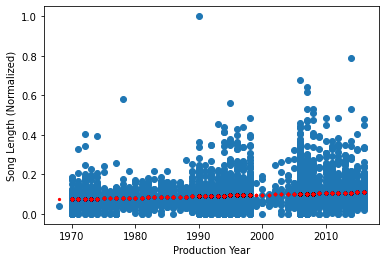

In [46]:
plt.scatter(x, y) # Actual (No subset)
plt.scatter(x, ypred_all, c = 'r', s = 5) # Predicted Y
plt.ylabel("Song Length (Normalized)")
plt.xlabel("Production Year")
plt.show()

# Hide output
None

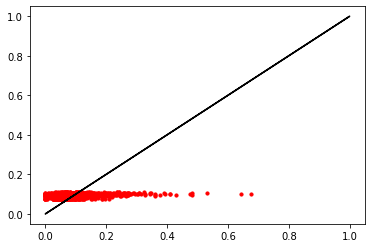

In [56]:
# Basically a density chart
plt.plot(y, y, c = "black")
plt.scatter(ytest, ypred_test, s = 10, c = "r")

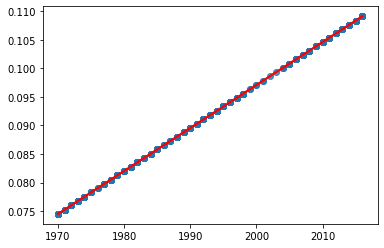

In [20]:
# Optional: Use Seaborn
sns.regplot(x = xtest, y = ypred_test, line_kws = {"color": "red"})

# Hide Output
None

### Part F - Model Assessment
 +
 
 +
 
 +
 
 +
 
*Student answer here, taking into account the key values of the model, as well as the graph and how well it aligns with predicted values.*

## Part 2 - Regression of Ratio (D) Variable

In [21]:
# Pull x values from DF
# import numpy as np
x2 = df["Year"].values.reshape(-1, 1) # Need data as a column, not rows
# x = np.nan_to_num(x)

# Pull y values from DF
y2 = df["D"].values.reshape(-1, 1) # Need data as a column, not rows
# y = np.nan_to_num(y)

# Split the data using 25% of the rows
xtrain2, xtest2, ytrain2, ytest2 = train_test_split(x2, y2, test_size = 0.25)

In [22]:
# Define a new Linear Regression model
# from sklearn import linear_model
model2 = linear_model.LinearRegression()

# Fit training data
model2.fit(xtrain2, ytrain2)

# Run the prediction
ypred_test2 = model.predict(xtest2)

### Step A - Model Coefficient, Intercept
To predict a value, you would do coef_ + intercep_

In [23]:
# Pull Coefficient from Model
model2.coef_[0][0]

-0.00017708817761206904

In [24]:
# Pull the Intercept from Model
model2.intercept_[0]

0.9557000543433447

### Step B - Interpret Coefficient and Intercept
**Coefficient NOTE**:

The **sign** of a regression coefficient tells you whether there is a **positive or negative correlation between each independent variable and the dependent variable**. A positive coefficient indicates that as the value of the independent variable increases, the mean of the dependent variable also tends to increase. A negative coefficient suggests that as the independent variable increases, the dependent variable tends to decrease.

The **coefficient value signifies how much the mean of the dependent variable changes given a one-unit shift in the independent variable** while holding other variables in the model constant. This property of holding the other variables constant is crucial because it allows you to assess the effect of each variable in isolation from the others. [(Source)](https://statisticsbyjim.com/regression/interpret-coefficients-p-values-regression/)

**Intercept NOTE**:

The relationship between year and song length. The intercept (often labeled as constant) is the point where the function crosses the y-axis. In some analysis, the regression model only becomes significant when we remove the intercept, and the regression line reduces to `Y = bX + error`. [(Source)](https://www.analyticsinsight.net/why-is-intercept-important-in-regression-analysis/)

 +
 
 +
 
 +
 
 +
 
*Student answer here, taking into account the purpose of coefficient and intercept.*

### Step C - Model R<sup>2</sup> Figure

**NOTE**:

R-squared is a goodness-of-fit measure for linear regression models. This statistic indicates the percentage of the variance in the dependent variable that the independent variables explain collectively. R-squared measures the strength of the relationship between your model and the dependent variable on a convenient 0 – 100% scale. [(Source)](https://statisticsbyjim.com/regression/interpret-r-squared-regression/)

In [25]:
metrics.r2_score(ytest2, ypred_test2)

-6.546079855349983

In [26]:
# Optional: Calculate LinearRegression performance
# Only used if you need to compare performance of LinearRegression vs. another type
# Calculate error between calculated (model) points and actual points
cve2 = cross_val_score(linear_model.LinearRegression(), x2, y2, cv = 10)

# Print Result
print("Linear model average error " + str(np.mean(cve2)))

Linear model average error -0.004108722100013696


### Step D - Plot the Model

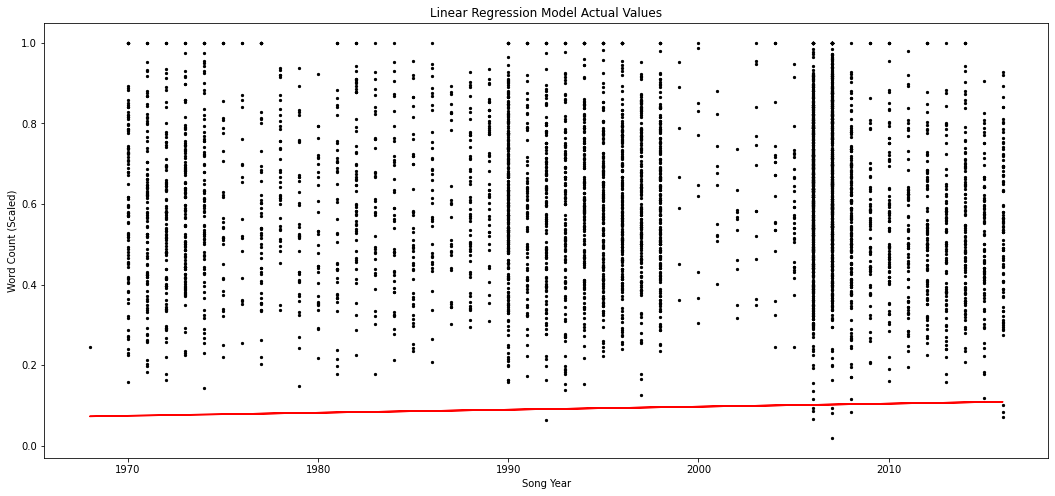

In [27]:
# Plot Actual Data
plt.figure(figsize = (18, 8))
plt.scatter(x2, y2, c = "black", s = 5)
plt.plot(xtest2, ypred_test2, c = "red") # Predicted Data

# Add labels
plt.title("Linear Regression Model Actual Values")
plt.xlabel("Song Year")
plt.ylabel("Word Count (Scaled)")

# Hide output
None

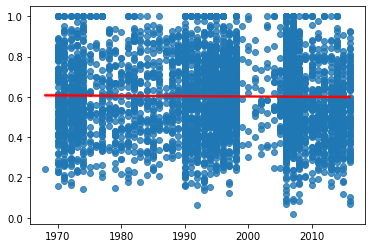

In [28]:
# Optional: Use Seaborn 
sns.regplot(x = x2, y = y2, line_kws = {"color": "red"})

# Hide Output
None

### Step E - Plot Predicted vs. Actual Y-Axis

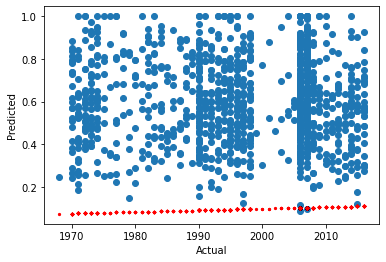

In [29]:
plt.scatter(xtest2, ytest2) # Actual Y (Test Subset)
plt.scatter(xtest2, ypred_test2, c = 'r', s = 5) # Predicted Y
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

# Hide output
None

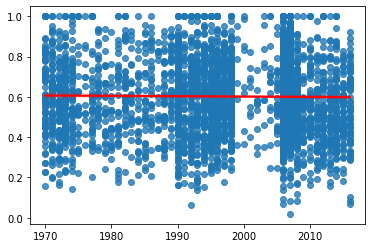

In [30]:
# Optional: Use Seaborn
sns.regplot(x = xtrain2, y = ytrain2, line_kws = {"color": "red"})

# Hide Output
None

### Step F - Additional Polynomial Terms
Find a model with the lowest degree of error

In [31]:
# Define lists to hold data points
errors = []
vrs = []

# Calculate CVE by N-th degree
for degree in range(10):
    pf = PolynomialFeatures(degree = degree)
    xnew = pf.fit_transform(x)
    model = linear_model.LinearRegression()
    cve = cross_val_score(model, xnew, y, cv = 20, scoring="neg_mean_squared_error")
    errors.append(cve.mean())
    vrs.append(cve.std())

In [32]:
errors

[-0.005324267595037422,
 -0.005197179033704389,
 -0.005195442962298833,
 -0.005192552238161711,
 -0.005192498557328092,
 -0.005192443544103894,
 -0.00519238883783313,
 -0.005192334444603776,
 -0.005192280371030396,
 -0.005192226622085934]

In [33]:
vrs

[0.001857467464646722,
 0.0018420395910543506,
 0.0018371563106229479,
 0.0018230715186015145,
 0.0018230095181784214,
 0.0018229489757113665,
 0.0018228895299940533,
 0.0018228311811549762,
 0.001822773926751743,
 0.0018227177679664736]

### Step G - Plot Cross-Validation Error

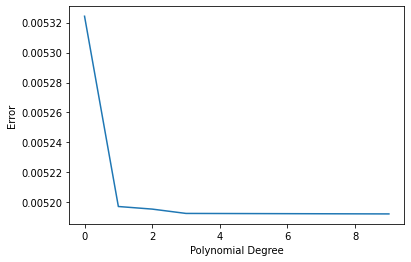

In [34]:
plt.plot(range(10), np.negative(errors))
plt.xlabel('Polynomial Degree')
plt.ylabel('Error');

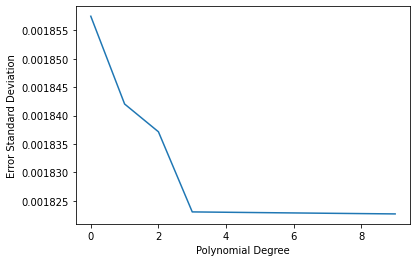

In [35]:
# Optional: Plot standard deviation between each cve fold
plt.plot(range(10), vrs)
plt.xlabel('Polynomial Degree')
plt.ylabel('Error Standard Deviation');

### Step H - The Best Degree
 +
 
 +
 
 +
 
 +
 
*Student answer here, taking into account that the best answer is the one that requires the lowest amount of computational resources and provides the best accuracy.*